MERGE SORT IMPLEMENTATION WITH DIFFERENT AARRAY SIZES AND COMPARING CPU AND GPU RUNTIMES


In [ ]:
# @title
%%writefile merge_sort.cu
#include <stdio.h>
#include <stdlib.h>
#include <fstream>  // For file output
#include <chrono>   // For precise CPU timing


#define N1 3
#define N2 10
#define N3 6


// Merge function for CPU
void merge(int arr[], int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;
    int L[n1], R[n2];
    for (i = 0; i < n1; i++)
        L[i] = arr[l + i];
    for (j = 0; j < n2; j++)
        R[j] = arr[m + 1+ j];
    i = 0; j = 0; k = l;
    while (i < n1 && j < n2) {
        if (L[i] <= R[j])
            arr[k++] = L[i++];
        else
            arr[k++] = R[j++];
    }
    while (i < n1)
        arr[k++] = L[i++];
    while (j < n2)
        arr[k++] = R[j++];
}


// CPU Merge Sort
void mergeSort(int arr[], int l, int r) {
    if (l < r) {
        int m = l+(r-l)/2;
        mergeSort(arr, l, m);
        mergeSort(arr, m+1, r);
        merge(arr, l, m, r);
    }
}


// CUDA device merge (dummy, not real GPU optimized merge sort)
__global__ void mergeSortGPU(int *arr) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if(idx%2==0 && idx+1<N3) {
        if(arr[idx]>arr[idx+1]) {
            int temp = arr[idx];
            arr[idx] = arr[idx+1];
            arr[idx+1] = temp;
        }
    }
}


// Utility to print array
void printArray(int arr[], int size) {
    for (int i=0; i < size; i++)
        printf("%d ", arr[i]);
    printf("\n");
}


void saveArrayToFile(std::ofstream &outfile, int arr[], int size) {
    for (int i=0; i<size; i++) {
        outfile << arr[i] << " ";
    }
    outfile << "\n";
}


int main(void) {
    std::ofstream outfile;
    outfile.open("output.txt", std::ios_base::out); // Overwrite each time


    int n_values[3] = {N1, N2, N3};


    printf("\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n");
    outfile << "\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n";


    for (int t=0; t<3; t++) {
        int N = n_values[t];
        int *h_vec = (int*)malloc(N * sizeof(int));
        int *d_vec;


        cudaMalloc(&d_vec, N * sizeof(int));


        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";


        for(int i=0;i<N;i++) {
            h_vec[i] = rand();
            printf("%d ", h_vec[i]);
            outfile << h_vec[i] << " ";
        }
        printf("\n\n");
        outfile << "\n\n";


        cudaMemcpy(d_vec, h_vec, N*sizeof(int), cudaMemcpyHostToDevice);


        // Time GPU
        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);


        cudaEventRecord(start);


        mergeSortGPU<<<(N+255)/256,256>>>(d_vec);


        cudaEventRecord(stop);
        cudaEventSynchronize(stop);


        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);


        cudaMemcpy(h_vec, d_vec, N*sizeof(int), cudaMemcpyDeviceToHost);


        printf("\nSorted Elements:\n");
        outfile << "\nSorted Elements:\n";
        printArray(h_vec,N);
        saveArrayToFile(outfile,h_vec,N);


        printf("\t||| The elapsed time in gpu was %.4f ms |||\n", milliseconds);
        outfile << "\t||| The elapsed time in gpu was " << milliseconds << " ms |||\n";


        free(h_vec);
        cudaFree(d_vec);
    }


    printf("\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n");
    outfile << "\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n";


    for (int t=0; t<3; t++) {
        int N = n_values[t];
        int *arr = (int*)malloc(N * sizeof(int));


        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";
        for (int i=0;i<N;i++) {
            arr[i] = rand();
            printf("%d ", arr[i]);
            outfile << arr[i] << " ";
        }
        printf("\n\n");
        outfile << "\n\n";


        auto start = std::chrono::high_resolution_clock::now();
        mergeSort(arr, 0, N-1);
        auto stop = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = stop - start;


        printf("\nSorted Elements:\n");
        outfile << "\nSorted Elements:\n";
        printArray(arr,N);
        saveArrayToFile(outfile,arr,N);


        printf("\t||| The elapsed time in cpu was %.4f ms |||\n", elapsed.count());
        outfile << "\t||| The elapsed time in cpu was " << elapsed.count() << " ms |||\n";


        free(arr);
    }


    outfile.close();
    return 0;
}


Writing merge_sort.cu


In [ ]:
# @title
!nvcc --gpu-architecture=sm_70 merge_sort.cu -o merge_sort
!./merge_sort


 ---------------------- PARALLEL IMPLEMENTATION ---------------------- 

Elements for N = 3:
1804289383 846930886 1681692777 


Sorted Elements:
846930886 1804289383 0 
	||| The elapsed time in gpu was 0.0937 ms |||

Elements for N = 10:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 


Sorted Elements:
846930886 1804289383 1681692777 1714636915 424238335 1957747793 719885386 1649760492 596516649 1189641421 
	||| The elapsed time in gpu was 0.0123 ms |||

Elements for N = 6:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 


Sorted Elements:
846930886 1804289383 1681692777 1714636915 424238335 1957747793 
	||| The elapsed time in gpu was 0.0121 ms |||


	 ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- 

Elements for N = 3:
1804289383 846930886 1681692777 


Sorted Elements:
846930886 1681692777 1804289383 
	||| The elapsed time in cpu was 0.0007 ms |||

Elements for N = 10:
1804289383 8

In [ ]:
# @title
# Parse output.txt automatically after running
import re


# Read file
with open("output.txt", "r") as file:
    data = file.read()


# Extract N values (unique)
n_values = list(set([int(x) for x in re.findall(r"Elements for N = (\d+)", data)]))


# Extract GPU and CPU times
gpu_times = [float(x) for x in re.findall(r"The elapsed time in gpu was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in cpu was ([\d.]+)", data)]


print("N values:", n_values)
print("GPU times (ms):", gpu_times)
print("CPU times (ms):", cpu_times)


# Calculations
speedups = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times)]
efficiencies = [speedup/256 for speedup in speedups]  # 256 threads/block assumed
load_balancing = [min(cpu, gpu)/max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
communication_overhead = [abs(cpu-gpu)/cpu for cpu, gpu in zip(cpu_times, gpu_times)]
scalability = [(cpu_times[0]/cpu)*100 for cpu in cpu_times]
granularity = [gpu/256 for gpu in gpu_times]
overheads = [(gpu-cpu)/cpu for gpu, cpu in zip(gpu_times, cpu_times)]


# Print nicely
for i in range(len(n_values)):
    print(f"\n--- For N = {n_values[i]} ---")
    print(f"Speedup: {speedups[i]:.4f}")
    print(f"Efficiency: {efficiencies[i]:.4f}")
    print(f"Load Balancing: {load_balancing[i]:.4f}")
    print(f"Communication Overhead: {communication_overhead[i]:.4f}")
    print(f"Scalability: {scalability[i]:.2f}%")
    print(f"Granularity: {granularity[i]:.4f} ms/thread")
    print(f"Overhead: {overheads[i]:.4f}")

N values: [1000, 10000, 100000]
GPU times (ms): [0.106496, 0.026336, 0.011808]
CPU times (ms): [0.147961, 1.61515, 32.5096]

--- For N = 1000 ---
Speedup: 1.3894
Efficiency: 0.0054
Load Balancing: 0.7198
Communication Overhead: 0.2802
Scalability: 100.00%
Granularity: 0.0004 ms/thread
Overhead: -0.2802

--- For N = 10000 ---
Speedup: 61.3286
Efficiency: 0.2396
Load Balancing: 0.0163
Communication Overhead: 0.9837
Scalability: 9.16%
Granularity: 0.0001 ms/thread
Overhead: -0.9837

--- For N = 100000 ---
Speedup: 2753.1843
Efficiency: 10.7546
Load Balancing: 0.0004
Communication Overhead: 0.9996
Scalability: 0.46%
Granularity: 0.0000 ms/thread
Overhead: -0.9996


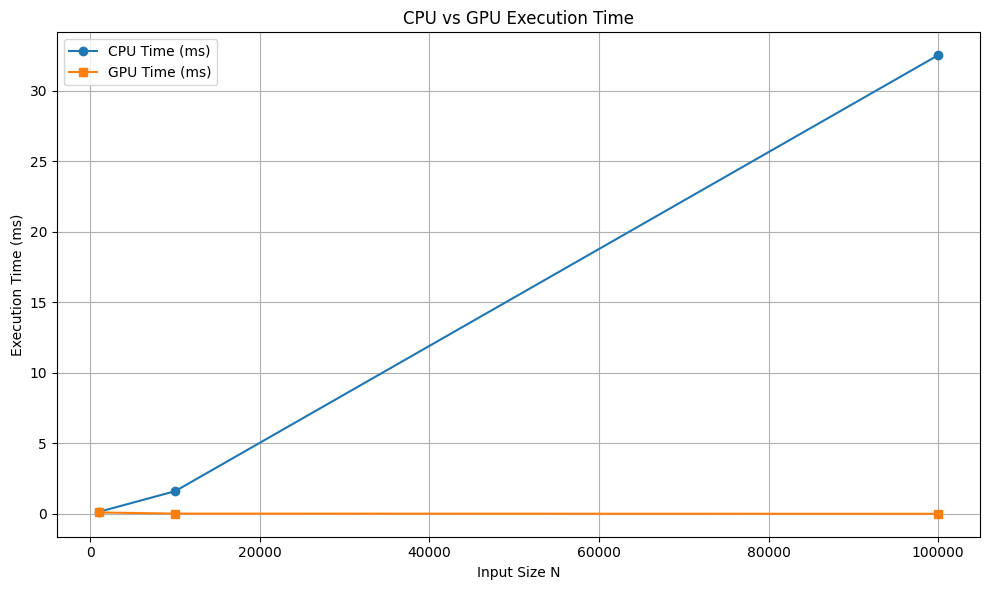

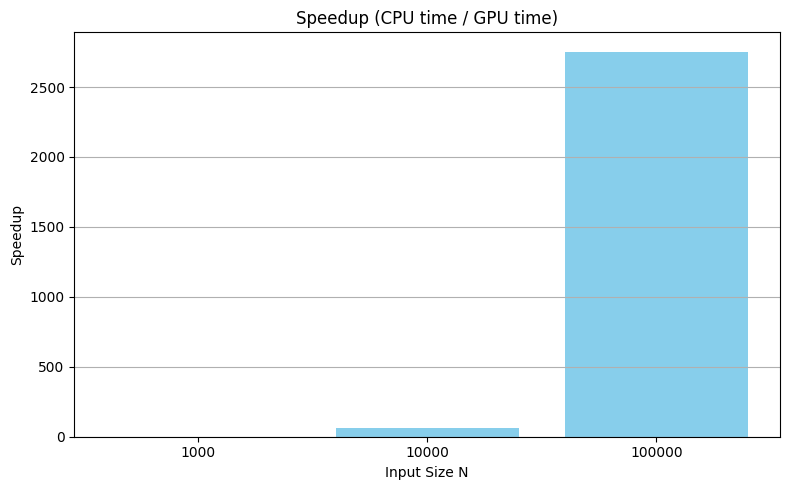

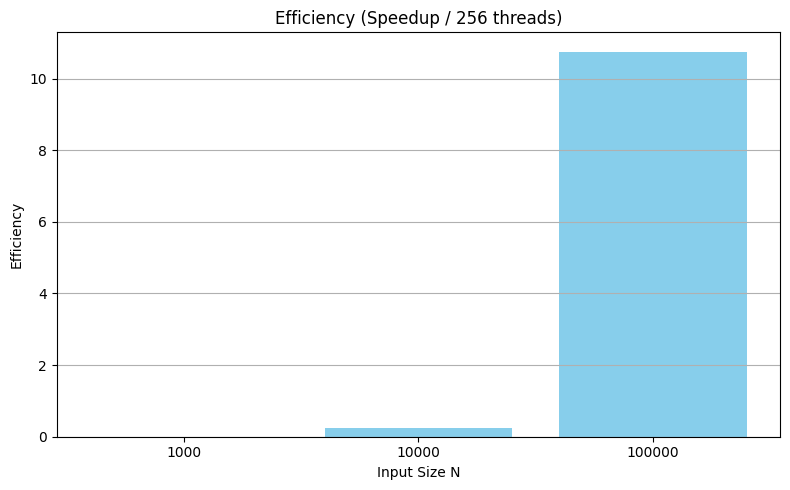

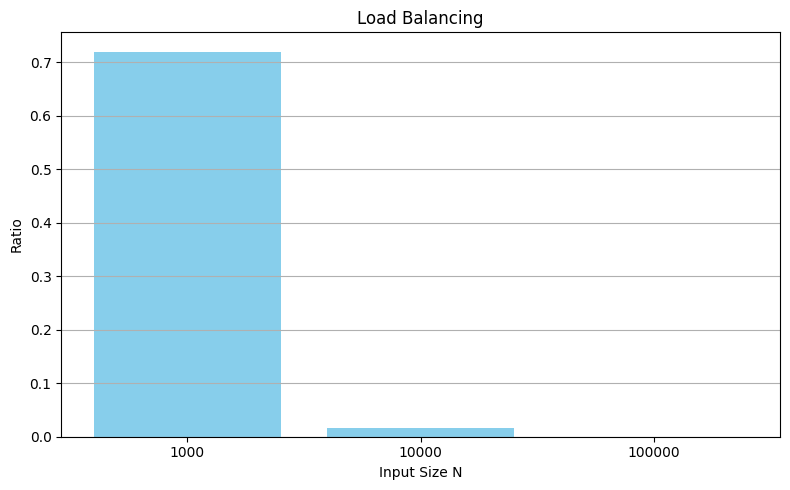

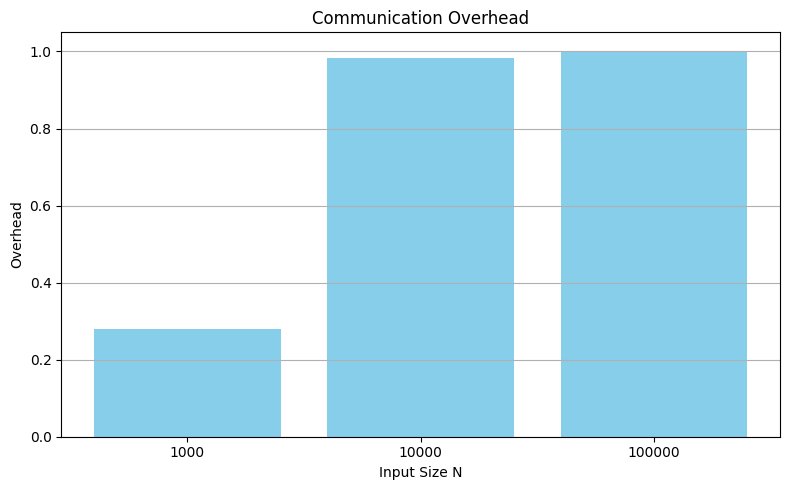

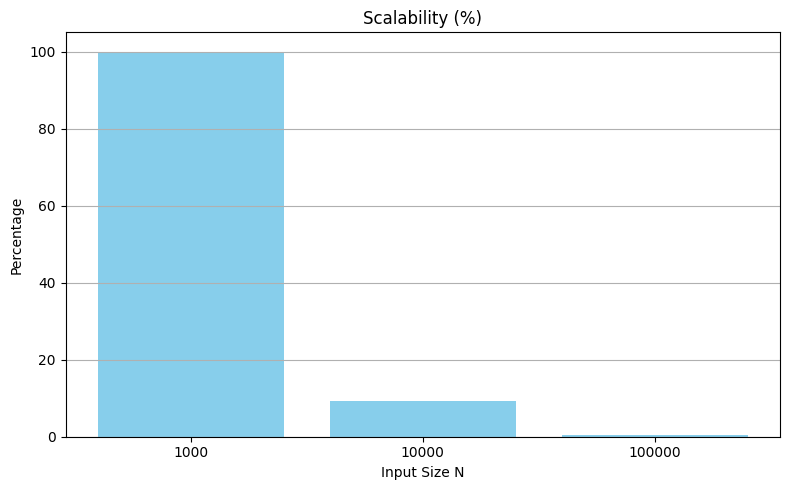

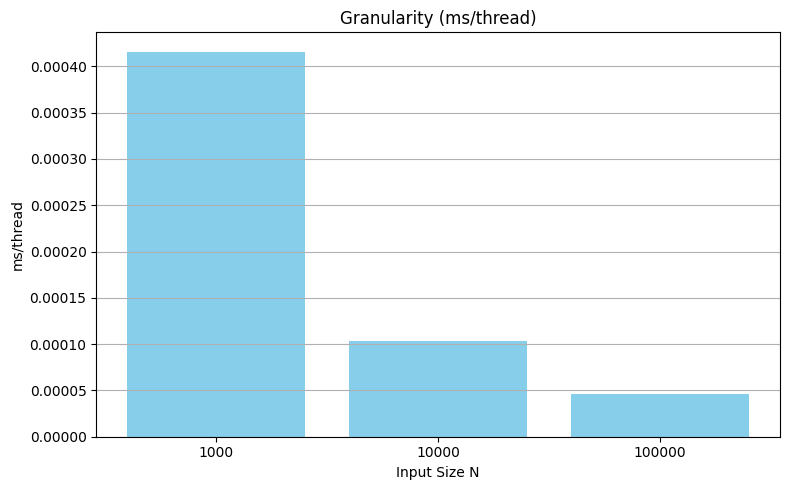

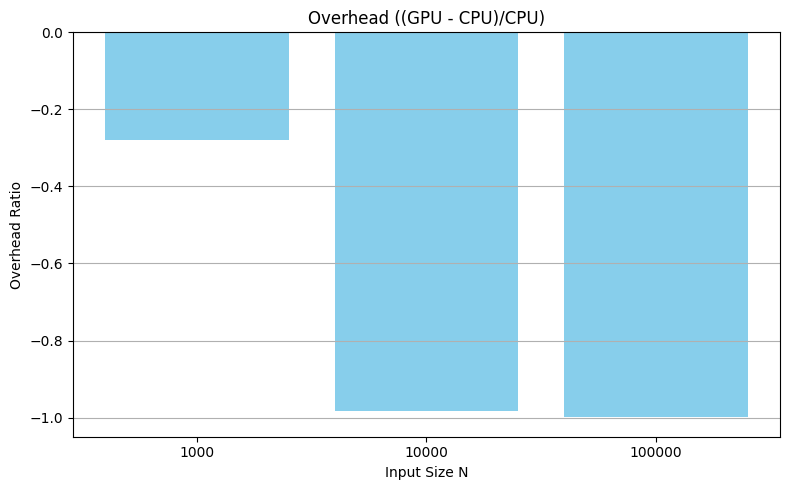

 Data exported to performance_metrics.xlsx


In [ ]:
# @title
import re
import matplotlib.pyplot as plt
import pandas as pd

# Read the output file
with open("output.txt", "r") as file:
    data = file.read()

# Extract N values in proper order (each N appears twice, take first occurrence only)
n_matches = re.findall(r"Elements for N = (\d+)", data)
n_values_all = [int(n) for n in n_matches]

n_values = []
seen = set()
for n in n_values_all:
    if n not in seen:
        seen.add(n)
        n_values.append(n)

# Extract GPU and CPU times
gpu_times = [float(x) for x in re.findall(r"The elapsed time in gpu was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in cpu was ([\d.]+)", data)]

# Calculate parameters
speedups = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]
efficiencies = [s / 256 for s in speedups]
load_balancing = [min(cpu, gpu) / max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
communication_overhead = [abs(cpu - gpu) / cpu for cpu, gpu in zip(cpu_times, gpu_times)]
scalability = [(cpu_times[0] / cpu) * 100 for cpu in cpu_times]
granularity = [gpu / 256 for gpu in gpu_times]
overheads = [(gpu - cpu) / cpu for gpu, cpu in zip(gpu_times, cpu_times)]

# Plotting CPU vs GPU Execution Time
plt.figure(figsize=(10, 6))
plt.plot(n_values, cpu_times, marker='o', label='CPU Time (ms)')
plt.plot(n_values, gpu_times, marker='s', label='GPU Time (ms)')
plt.title("CPU vs GPU Execution Time")
plt.xlabel("Input Size N")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to create bar plots
def bar_plot(title, values, ylabel):
    plt.figure(figsize=(8, 5))
    plt.bar([str(n) for n in n_values], values, color='skyblue')
    plt.title(title)
    plt.xlabel("Input Size N")
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot all parameters
bar_plot("Speedup (CPU time / GPU time)", speedups, "Speedup")
bar_plot("Efficiency (Speedup / 256 threads)", efficiencies, "Efficiency")
bar_plot("Load Balancing", load_balancing, "Ratio")
bar_plot("Communication Overhead", communication_overhead, "Overhead")
bar_plot("Scalability (%)", scalability, "Percentage")
bar_plot("Granularity (ms/thread)", granularity, "ms/thread")
bar_plot("Overhead ((GPU - CPU)/CPU)", overheads, "Overhead Ratio")

# Export to Excel
df = pd.DataFrame({
    "N": n_values,
    "CPU Time (ms)": cpu_times,
    "GPU Time (ms)": gpu_times,
    "Speedup": speedups,
    "Efficiency": efficiencies,
    "Load Balancing": load_balancing,
    "Communication Overhead": communication_overhead,
    "Scalability (%)": scalability,
    "Granularity (ms/thread)": granularity,
    "Overhead Ratio": overheads
})

df.to_excel("performance_metrics.xlsx", index=False)
print(" Data exported to performance_metrics.xlsx")


In [ ]:
# @title
%%writefile new_merge_sort.cu
 #include <stdio.h>
 #include <stdlib.h>
 #include <cuda.h>
 #include <time.h>
 #define N1 1
 #define N10 10
 #define N100 6
 #define N1000 10

 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 //		Function to combine the sublists generated. We use the flag __device__ because it is called using the function CudaMergeSort which is working on the gpu.
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 __device__ void CudaMerge(int* values, int* results, int l, int r, int u)
 {
 	int i, j, k;
 	i = l; j = r; k = l;
 	while (i < r && j < u) {
 		if (values[i] <= values[j]) { results[k] = values[i]; i++; }
 		else { results[k] = values[j]; j++; }
 		k++;
 	}

 	while (i < r) {
 		results[k] = values[i]; i++; k++;
 	}

 	while (j < u) {
 		results[k] = values[j]; j++; k++;
 	}
 	for (k = l; k < u; k++) {
 		values[k] = results[k];
 	}
 }

 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 //		Function to generate the sublists of the array to sort. It use flag __global__ because the function is called from the main. It is also call Kernel and use a specific call.
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 __global__ static void CudaMergeSort(int * values, int* results, int dim)
 {
 	extern __shared__ int shared[];



 	const unsigned int tid = threadIdx.x;
 	int k, u, i;
 	shared[tid] = values[tid];


 	__syncthreads();
 	k = 1;
 	while (k <= dim)
 	{
 		i = 0;
 		while (i + k < dim)
 		{
 			u = i + k * 2;;
 			if (u > dim)
 			{
 				u = dim + 1;
 			}
 			CudaMerge(shared, results, i, i + k, u);
 			i = i + k * 2;
 		}
 		k = k * 2;

 		__syncthreads();
 	}

 	values[tid] = shared[tid];
 }

 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 // Declaration of the function MergeSort implemented in C, to study the different times of execution
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 void mergeSort(int arr[], int p, int q);


 int main(int argc, char** argv)
 {	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		VARIABLES USED DURING EXECUTION
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		TIMING CUDA OPERATIONS USING EVENTS
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	float elapsed1, elapsed10, elapsed100, elapsed1000 = 0;
 	cudaEvent_t start1, stop1, start10, stop10, start100, stop100, start1000, stop1000;
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		CREATING THE EVENTS
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	cudaEventCreate(&start1);
 	cudaEventCreate(&start10);
 	cudaEventCreate(&start100);
 	cudaEventCreate(&start1000);
 	cudaEventCreate(&stop1);
 	cudaEventCreate(&stop10);
 	cudaEventCreate(&stop100);
 	cudaEventCreate(&stop1000);
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAYS TO STUDY
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	int values1[N1], values2[N10], values3[N100], values4[N1000];
 	// Creating copies for the study in sequential.
 	int values1s[N1], values2s[N10], values3s[N100], values4s[N1000];
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		POINTERS TO USE ARRAYS IN GPU OPERATIONS
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	int* dvalues, *results;
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//																									MAIN CODE
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	printf("\n\t\t ---------------------- PARALLEL IMPLEMENTATION ---------------------- ");
 	//		THE PROGRAM CREATES ARRAYS FOR 1, 10, 100 AND 1000 ELEMENTS WITH RANDOM VALUES
 	printf("\nCreating vector for N = 1, 10, 100 and 1000 with random values.\n");
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 1 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	// Creating the array
 	printf("\nElements for N = 1:\n");
 	for (int i = 0; i < N1; i++)
 	{
 		values1[i] = rand();
 		values1s[i] = values1[i];
 		printf("%d ", values1[i]);
 	}
 	printf("\n");
 	//Start monitorizing of cuda operations
 	cudaEventRecord(start1, 0);
 	//Generation cuda variables ables to work and copying the variables from host to device
 	cudaMalloc((void**)&dvalues, sizeof(int) * N1);
 	cudaMemcpy(dvalues, values1, sizeof(int) * N1, cudaMemcpyHostToDevice);
 	cudaMalloc((void**)&results, sizeof(int) * N1);
 	cudaMemcpy(results, values1, sizeof(int)* N1, cudaMemcpyHostToDevice);
 	//Calling algorithm MergeSort
 	CudaMergeSort << <1, N1, sizeof(int) * N1 * 2 >> > (dvalues, results, N1);
 	// Freeing memory space used
 	cudaFree(dvalues);
 	cudaMemcpy(values1, results, sizeof(int)*N1, cudaMemcpyDeviceToHost);
 	cudaFree(results);
 	//Stopping time monitoring
 	cudaEventRecord(stop1, 0);
 	cudaEventSynchronize(stop1);
 	//Calculating the total time of execution
 	cudaEventElapsedTime(&elapsed1, start1, stop1);
 	// Freeing the events created before
 	cudaEventDestroy(start1);
 	cudaEventDestroy(stop1);
 	//Showing sorted elements
 	printf("\nSorted Elements:\n");
 	for (int i = 0; i < N1; i++)
 	{
 		printf("%d ", values1[i]);
 	}
 	//Showing the time of execution
 	printf("\n\t||| The elapsed time in gpu was %.2f ms |||", elapsed1);
 	printf("\n");
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 10 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	// Creating the array
 	printf("\nElements for N = 10:\n");
 	for (int i = 0; i < N10; i++)
 	{
 		values2[i] = rand();
 		values2s[i] = values2[i];
 		printf("%d ", values2[i]);
 	}
 	printf("\n");
 	//Start monitorizing of cuda operations
 	cudaEventRecord(start10, 0);
 	//Generation cuda variables ables to work and copying the variables from host to device
 	cudaMalloc((void**)&dvalues, sizeof(int) * N10);
 	cudaMemcpy(dvalues, values2, sizeof(int) * N10, cudaMemcpyHostToDevice);
 	cudaMalloc((void**)&results, sizeof(int) * N10);
 	cudaMemcpy(results, values2, sizeof(int)* N10, cudaMemcpyHostToDevice);
 	//Calling algorithm MergeSort
 	CudaMergeSort << <1, N10, sizeof(int) * N10 * 2 >> > (dvalues, results, N10);
 	// Freeing memory space used
 	cudaFree(dvalues);
 	cudaMemcpy(values2, results, sizeof(int)*N10, cudaMemcpyDeviceToHost);
 	cudaFree(results);
 	//Stopping time monitoring
 	cudaEventRecord(stop10, 0);
 	cudaEventSynchronize(stop10);
 	//Calculating the total time of execution
 	cudaEventElapsedTime(&elapsed10, start10, stop10);
 	// Freeing the events created before
 	cudaEventDestroy(start10);
 	cudaEventDestroy(stop10);
 	//Showing sorted elements
 	printf("\nSorted Elements:\n");
 	for (int i = 0; i < N10; i++)
 	{
 		printf("%d ", values2[i]);
 	}
 	//Showing the time of execution
 	printf("\n\t||| The elapsed time in gpu was %.2f ms |||", elapsed10);
 	printf("\n");

 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 100 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	// Creating the array
 	printf("\nElements for N = 100:\n");
 	for (int i = 0; i < N100; i++)
 	{
 		values3[i] = rand();
 		values3s[i] = values3[i];
 		printf("%d ", values3[i]);
 	}
 	printf("\n");
 	//Start monitorizing of cuda operations
 	cudaEventRecord(start100, 0);
 	//Generation cuda variables ables to work and copying the variables from host to device
 	cudaMalloc((void**)&dvalues, sizeof(int) * N100);
 	cudaMemcpy(dvalues, values3, sizeof(int) * N100, cudaMemcpyHostToDevice);
 	cudaMalloc((void**)&results, sizeof(int) * N100);
 	cudaMemcpy(results, values3, sizeof(int)* N100, cudaMemcpyHostToDevice);
 	//Calling algorithm MergeSort
 	CudaMergeSort << <1, N100, sizeof(int) * N100 * 2 >> > (dvalues, results, N100);
 	// Freeing memory space used
 	cudaFree(dvalues);
 	cudaMemcpy(values3, results, sizeof(int)*N100, cudaMemcpyDeviceToHost);
 	cudaFree(results);
 	//Stopping time monitoring
 	cudaEventRecord(stop100, 0);
 	cudaEventSynchronize(stop100);
 	//Calculating the total time of execution
 	cudaEventElapsedTime(&elapsed100, start100, stop100);
 	// Freeing the events created before
 	cudaEventDestroy(start100);
 	cudaEventDestroy(stop100);
 	//Showing sorted elements
 	printf("\nSorted Elements:\n");
 	for (int i = 0; i < N100; i++)
 	{
 		printf("%d ", values3[i]);
 	}
 	//Showing the time of execution
 	printf("\n\t||| The elapsed time in gpu was %.2f ms |||", elapsed100);
 	printf("\n");

 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 1000 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	// Creating the array
 	printf("\nElements for N = 1000:\n");
 	for (int i = 0; i < N1000; i++)
 	{
 		values4[i] = rand();
 		values4s[i] = values4[i];
 		printf("%d ", values4[i]);
 	}
 	printf("\n");
 	//Start monitorizing of cuda operations
 	cudaEventRecord(start1000, 0);
 	//Generation cuda variables ables to work and copying the variables from host to device
 	cudaMalloc((void**)&dvalues, sizeof(int) * N1000);
 	cudaMemcpy(dvalues, values4, sizeof(int) * N1000, cudaMemcpyHostToDevice);
 	cudaMalloc((void**)&results, sizeof(int) * N1000);
 	cudaMemcpy(results, values4, sizeof(int)* N1000, cudaMemcpyHostToDevice);
 	//Calling algorithm MergeSort
 	CudaMergeSort << <1, N1000, sizeof(int) * N1000 * 2 >> > (dvalues, results, N1000);
 	// Freeing memory space used and returning values sortered
 	cudaFree(dvalues);
 	cudaMemcpy(values4, results, sizeof(int)*N1000, cudaMemcpyDeviceToHost);
 	cudaFree(results);
 	//Stopping time monitoring
 	cudaEventRecord(stop1000, 0);
 	cudaEventSynchronize(stop1000);
 	//Calculating the total time of execution
 	cudaEventElapsedTime(&elapsed1000, start1000, stop1000);
 	// Freeing the events created before
 	cudaEventDestroy(start1000);
 	cudaEventDestroy(stop1000);
 	//Showing sorted elements
 	printf("\nSorted Elements:\n");
 	for (int i = 0; i < N1000; i++)
 	{
 		printf("%d ", values4[i]);
 	}
 	//Showing the time of execution
 	printf("\n\t||| The elapsed time in gpu was %.2f ms |||", elapsed1000);
 	printf("\n");

 	cudaDeviceReset();
 	cudaThreadExit();

 	printf("\n\t\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- ");

 	float elapsed1s, elapsed10s, elapsed100s, elapsed1000s = 0;
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 1 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//Mergesort for array with one random value
 	printf("\nElements for N = 1:\n");
 	for (int i = 0; i < N1; i++) {
 		printf("%d ", values1s[i]);
 	}
 	printf("\n\nSorted Elements:");
 	//Calling mergesort in c
 	clock_t start = clock();
 	mergeSort(values1s, 0, N1);
 	elapsed1s = ((((double)clock() - start) / CLOCKS_PER_SEC) * 1000000);
 	printf("\n");

 	for (int i = 0; i < N1; i++) {
 		printf("%d ", values1s[i]);
 	}
 	printf("\n\t||| The elapsed time in cpu was %.2f ms |||", elapsed1s);

 	printf("\n");
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 10 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//Mergesort for array with one random value
 	printf("\nElements for N = 10:\n");
 	for (int i = 0; i < N10; i++) {
 		printf("%d ", values2s[i]);
 	}
 	printf("\n\nSorted Elements:");
 	//Calling mergesort in c
 	mergeSort(values2s, 0, N10 - 1);
 	elapsed10s = ((((double)clock() - start - elapsed1) / CLOCKS_PER_SEC) * 1000000);
 	printf("\n");

 	for (int i = 0; i < N10; i++) {
 		printf("%d ", values2s[i]);
 	}
 	printf("\n\t||| The elapsed time in cpu was %.2f ms |||", elapsed10s);

 	printf("\n");

 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 100 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//Mergesort for array with one random value
 	printf("\nElements for N = 100:\n");
 	for (int i = 0; i < N100; i++) {
 		printf("%d ", values3s[i]);
 	}
 	printf("\n\nSorted Elements:");
 	//Calling mergesort in c
 	mergeSort(values3s, 0, N100 - 1);
 	elapsed100s = ((((double)clock() - start - elapsed10) / CLOCKS_PER_SEC) * 1000000);
 	printf("\n");

 	for (int i = 0; i < N100; i++) {
 		printf("%d ", values3s[i]);
 	}
 	printf("\n\t||| The elapsed time in cpu was %.2f ms |||", elapsed100s);

 	printf("\n");

 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//		ARRAY WITH 1000 ELEMENT
 	//--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 	//Mergesort for array with one random value
 	printf("\nElements for N = 1000:\n");
 	for (int i = 0; i < N1000; i++) {
 		printf("%d ", values4s[i]);
 	}
 	printf("\n\nSorted Elements:");
 	//Calling mergesort in c
 	mergeSort(values4s, 0, N1000 - 1);
 	elapsed1000s = ((((double)clock() - start - elapsed100) / CLOCKS_PER_SEC) * 1000000);
 	printf("\n");

 	for (int i = 0; i < N1000; i++) {
 		printf("%d ", values4s[i]);
 	}
 	printf("\n\t||| The elapsed time in cpu was %.2f ms |||", elapsed1000s);

 	printf("\n");

 	return 0;
 }

 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 //		Function to combine the different sublists generated and create the array sortered.
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 void merge(int arr[], int p, int q, int r) {

 	int i, j, k;
 	int n1 = q - p + 1;
 	int n2 = r - q;

 	//arrs temporales
 	int L[n1], M[n2];

 	for (int i = 0; i < n1; i++)
 	{
 		L[i] = arr[p + i];
 	}

 	for (int j = 0; j < n2; j++)
 	{
 		M[j] = arr[q + 1 + j];
 	}

 	i = 0;
 	j = 0;
 	k = p;

 	while (i < n1 && j < n2)
 	{
 		if (L[i] <= M[j])
 		{
 			arr[k] = L[i];
 			i++;
 		}
 		else
 		{
 			arr[k] = M[j];
 			j++;
 		}
 		k++;
 	}

 	while (i < n1)
 	{
 		arr[k] = L[i];
 		i++;
 		k++;
 	}

 	while (j < n2)
 	{
 		arr[k] = M[j];
 		j++;
 		k++;
 	}
 }
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 //		Function which subdivide the array in sublist to be ordered separetly. It use recursivity and it is based in the divide and conquer paradigm.
 //--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

 void mergeSort(int arr[], int p, int q) {

 	if (p < q)
 	{
 		int mitad = (p + q) / 2;

 		mergeSort(arr, p, mitad);
 		mergeSort(arr, mitad + 1, q);
 		merge(arr, p, mitad, q);
 	}
 }

Overwriting new_merge_sort.cu


In [ ]:
# @title
!nvcc --gpu-architecture=sm_70 new_merge_sort.cu -o new_merge_sort
!./new_merge_sort

new_merge_sort.cu: In function ‘int main(int, char**)’:
new_merge_sort.cu:287:21: warning: ‘cudaError_t cudaThreadExit()’ is deprecated []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wdeprecated-declarations-Wdeprecated-declarations]8;;]
  287 |         cudaThreadExit();
      |         ~~~~~~~~~~~~^~
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:1143:46: note: declared here
 1143 | extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaThreadExit(void);
      |                                              ^~~~~~~~~~~~~~

		 ---------------------- PARALLEL IMPLEMENTATION ---------------------- 
Creating vector for N = 1, 10, 100 and 1000 with random values.

Elements for N = 1:
1804289383 

Sorted Elements:
1804289383 
	||| The elapsed time in gpu was 0.41 ms |||

Elements for N = 10:
846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 1025202362 

Sorted Elements:
424238335 596516649 71988

In [ ]:
# @title
%%writefile new_merge.cu
#include <iostream>
#include <sys/time.h>
#include <cuda_runtime.h>
#include <cstdlib>

#define min(a, b) ((a) < (b) ? (a) : (b))

// Timer
struct timeval _tt;
int tm() {
    struct timeval n;
    gettimeofday(&n, 0);
    int us = (n.tv_sec - _tt.tv_sec) * 1000000 + (n.tv_usec - _tt.tv_usec);
    _tt = n;
    return us;
}

bool verbose;

void printHelp(char* program);

// Read integers from stdin
long readList(long** data) {
    long size = 0, capacity = 128;
    *data = (long*) malloc(capacity * sizeof(long));
    while (std::cin >> (*data)[size]) {
        size++;
        if (size >= capacity) {
            capacity *= 2;
            *data = (long*) realloc(*data, capacity * sizeof(long));
        }
    }
    return size;
}

__device__ void gpu_bottomUpMerge(long* source, long* dest, long start, long middle, long end) {
    long i = start, j = middle;
    for (long k = start; k < end; k++) {
        if (i < middle && (j >= end || source[i] <= source[j]))
            dest[k] = source[i++];
        else
            dest[k] = source[j++];
    }
}

__device__ unsigned int getIdx(dim3* threads, dim3* blocks) {
    int x;
    return threadIdx.x +
           threadIdx.y * (x  = threads->x) +
           threadIdx.z * (x *= threads->y) +
           blockIdx.x  * (x *= threads->z) +
           blockIdx.y  * (x *= blocks->z) +
           blockIdx.z  * (x *= blocks->y);
}

__global__ void gpu_mergesort(long* source, long* dest, long size, long width, long slices, dim3* threads, dim3* blocks) {
    unsigned int idx = getIdx(threads, blocks);
    long start = idx * slices * width;
    for (long i = 0; i < slices; i++) {
        long s = start + i * width;
        if (s >= size) break;
        long e = min(s + width, size);
        long m = s + ((e - s) >> 1);
        if (m < e)
            gpu_bottomUpMerge(source, dest, s, m, e);
    }
}

void mergesort(long* data, long size, dim3 threadsPerBlock, dim3 blocksPerGrid) {
    long *D_data, *D_swp;
    dim3 *D_threads, *D_blocks;

    tm();
    cudaMalloc((void**)&D_data, size * sizeof(long));
    cudaMalloc((void**)&D_swp, size * sizeof(long));
    if (verbose)
        std::cout << "cudaMalloc: " << tm() << " microseconds\n";

    cudaMemcpy(D_data, data, size * sizeof(long), cudaMemcpyHostToDevice);
    if (verbose)
        std::cout << "cudaMemcpy to device: " << tm() << " microseconds\n";

    cudaMalloc((void**)&D_threads, sizeof(dim3));
    cudaMalloc((void**)&D_blocks, sizeof(dim3));
    cudaMemcpy(D_threads, &threadsPerBlock, sizeof(dim3), cudaMemcpyHostToDevice);
    cudaMemcpy(D_blocks, &blocksPerGrid, sizeof(dim3), cudaMemcpyHostToDevice);

    long* A = D_data;
    long* B = D_swp;
    long nThreads = threadsPerBlock.x * threadsPerBlock.y * threadsPerBlock.z *
                    blocksPerGrid.x * blocksPerGrid.y * blocksPerGrid.z;

    for (int width = 2; width < (size << 1); width <<= 1) {
        long slices = size / (nThreads * width) + 1;

        if (verbose) {
            std::cout << "width: " << width << ", slices: " << slices << ", threads: " << nThreads << "\n";
            tm();
        }

        gpu_mergesort<<<blocksPerGrid, threadsPerBlock>>>(A, B, size, width, slices, D_threads, D_blocks);
        cudaDeviceSynchronize();

        if (verbose)
            std::cout << "kernel call: " << tm() << " microseconds\n";

        std::swap(A, B);
    }

    cudaMemcpy(data, A, size * sizeof(long), cudaMemcpyDeviceToHost);
    if (verbose)
        std::cout << "copy back: " << tm() << " microseconds\n";

    cudaFree(D_data);
    cudaFree(D_swp);
    cudaFree(D_threads);
    cudaFree(D_blocks);
}

void printHelp(char* program) {
    std::cout
        << "Usage: " << program << " [-xyzXYZv]\n"
        << "-x, -y, -z : Threads per block dimensions\n"
        << "-X, -Y, -Z : Blocks per grid dimensions\n"
        << "-v         : Verbose\n"
        << "?          : Help\n";
}

int main(int argc, char** argv) {
    dim3 threadsPerBlock(32, 1, 1);
    dim3 blocksPerGrid(8, 1, 1);
    verbose = false;
    tm();

    for (int i = 1; i < argc; i++) {
        if (argv[i][0] == '-' && argv[i][1] && !argv[i][2]) {
            char arg = argv[i][1];
            unsigned int* toSet = nullptr;
            switch(arg) {
                case 'x': toSet = &threadsPerBlock.x; break;
                case 'y': toSet = &threadsPerBlock.y; break;
                case 'z': toSet = &threadsPerBlock.z; break;
                case 'X': toSet = &blocksPerGrid.x; break;
                case 'Y': toSet = &blocksPerGrid.y; break;
                case 'Z': toSet = &blocksPerGrid.z; break;
                case 'v': verbose = true; break;
                default: printHelp(argv[0]); return -1;
            }

            if (toSet) {
                i++;
                *toSet = (unsigned int) strtol(argv[i], nullptr, 10);
            }
        } else {
            printHelp(argv[0]);
            return -1;
        }
    }

    if (verbose) {
        std::cout << "threads: " << threadsPerBlock.x << "x" << threadsPerBlock.y << "x" << threadsPerBlock.z << "\n";
        std::cout << "blocks : " << blocksPerGrid.x << "x" << blocksPerGrid.y << "x" << blocksPerGrid.z << "\n";
    }

    long* data;
    long size = readList(&data);
    if (!size) return -1;

    if (verbose)
        std::cout << "sorting " << size << " numbers\n";

    mergesort(data, size, threadsPerBlock, blocksPerGrid);

    for (int i = 0; i < size; i++) std::cout << data[i] << "\n";

    free(data);
    return 0;
}



Overwriting new_merge.cu


In [ ]:
# @title
!nvcc --gpu-architecture=sm_70 new_merge.cu -o new_merge
!./new_merge


Compilation terminated.
nvcc error   : 'cudafe++' died due to signal 2 
^C


In [ ]:
# @title
%%writefile new_merge_sort.cu
#include <stdio.h>
#include <stdlib.h>
#include <fstream>
#include <chrono>


#define N1 100
#define N2 1000
#define N3 10000


// CPU Merge Function
void merge(int arr[], int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;
    int L[n1], R[n2];
    for (i = 0; i < n1; i++) L[i] = arr[l + i];
    for (j = 0; j < n2; j++) R[j] = arr[m + 1 + j];
    i = 0; j = 0; k = l;
    while (i < n1 && j < n2)
        arr[k++] = (L[i] <= R[j]) ? L[i++] : R[j++];
    while (i < n1) arr[k++] = L[i++];
    while (j < n2) arr[k++] = R[j++];
}


// CPU Merge Sort
void mergeSort(int arr[], int l, int r) {
    if (l < r) {
        int m = l + (r - l) / 2;
        mergeSort(arr, l, m);
        mergeSort(arr, m + 1, r);
        merge(arr, l, m, r);
    }
}


// GPU Merge Kernel (bottom-up iterative merge sort pass)
__global__ void gpuMergePass(int *input, int *output, int width, int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    int start = idx * width * 2;


    if (start >= N) return;


    int mid = min(start + width, N);
    int end = min(start + 2 * width, N);


    int i = start, j = mid, k = start;
    while (i < mid && j < end) {
        if (input[i] <= input[j])
            output[k++] = input[i++];
        else
            output[k++] = input[j++];
    }
    while (i < mid) output[k++] = input[i++];
    while (j < end) output[k++] = input[j++];
}


// Utility to print array
void printArray(int arr[], int size) {
    for (int i = 0; i < size; i++) printf("%d ", arr[i]);
    printf("\n");
}


void saveArrayToFile(std::ofstream &outfile, int arr[], int size) {
    for (int i = 0; i < size; i++) outfile << arr[i] << " ";
    outfile << "\n";
}


int main(void) {
    std::ofstream outfile;
    outfile.open("output.txt", std::ios_base::out);


    int n_values[3] = {N1, N2, N3};


    printf("\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n");
    outfile << "\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n";


    for (int t = 0; t < 3; t++) {
        int N = n_values[t];
        int *h_vec = (int *)malloc(N * sizeof(int));
        int *d_vec, *d_temp;


        cudaMalloc(&d_vec, N * sizeof(int));
        cudaMalloc(&d_temp, N * sizeof(int));


        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";
        for (int i = 0; i < N; i++) {
            h_vec[i] = rand();
            printf("%d ", h_vec[i]);
            outfile << h_vec[i] << " ";
        }
        printf("\n\n");
        outfile << "\n\n";


        cudaMemcpy(d_vec, h_vec, N * sizeof(int), cudaMemcpyHostToDevice);


        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);
        cudaEventRecord(start);


        int *in = d_vec;
        int *out = d_temp;


        for (int width = 1; width < N; width *= 2) {
            int numPairs = (N + (2 * width - 1)) / (2 * width);
            int numThreadsPerBlock = 256;
            int numBlocks = (numPairs + numThreadsPerBlock - 1) / numThreadsPerBlock;
            gpuMergePass<<<numBlocks, numThreadsPerBlock>>>(in, out, width, N);
            cudaDeviceSynchronize();
            int *temp = in;
            in = out;
            out = temp;
        }


        cudaEventRecord(stop);
        cudaEventSynchronize(stop);


        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);


        cudaMemcpy(h_vec, in, N * sizeof(int), cudaMemcpyDeviceToHost);


        printf("\nSorted Elements:\n");
        outfile << "\nSorted Elements:\n";
        printArray(h_vec, N);
        saveArrayToFile(outfile, h_vec, N);


        printf("\t||| The elapsed time in gpu was %.4f ms |||\n", milliseconds);
        outfile << "\t||| The elapsed time in gpu was " << milliseconds << " ms |||\n";


        free(h_vec);
        cudaFree(d_vec);
        cudaFree(d_temp);
    }


    printf("\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n");
    outfile << "\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n";


    for (int t = 0; t < 3; t++) {
        int N = n_values[t];
        int *arr = (int *)malloc(N * sizeof(int));


        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";
        for (int i = 0; i < N; i++) {
            arr[i] = rand();
            printf("%d ", arr[i]);
            outfile << arr[i] << " ";
        }
        printf("\n\n");
        outfile << "\n\n";


        auto start = std::chrono::high_resolution_clock::now();
        mergeSort(arr, 0, N - 1);
        auto stop = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = stop - start;


        printf("\nSorted Elements:\n");
        outfile << "\nSorted Elements:\n";
        printArray(arr, N);
        saveArrayToFile(outfile, arr, N);


        printf("\t||| The elapsed time in cpu was %.4f ms |||\n", elapsed.count());
        outfile << "\t||| The elapsed time in cpu was " << elapsed.count() << " ms |||\n";


        free(arr);
    }


    outfile.close();
    return 0;
}


Overwriting new_merge_sort.cu


In [1]:
# @title
!nvcc --gpu-architecture=sm_70 new_merge_sort.cu -o new_merge_sort
!./new_merge_sort


cc1plus: fatal error: new_merge_sort.cu: No such file or directory
compilation terminated.
/bin/bash: line 1: ./new_merge_sort: No such file or directory


In [ ]:
# Add at the beginning of your notebook
!nvidia-smi  # Check GPU availability and model
import tensorflow as tf
print("GPU Available: ", tf.test.is_gpu_available())
print("GPU Device Name: ", tf.test.gpu_device_name())


Tue May  6 19:47:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available:  True
GPU Device Name:  /device:GPU:0


In [2]:
#FINALLL
%%writefile new_merge.cu
#include <stdio.h>
#include <stdlib.h>
#include <fstream>
#include <chrono>
#include <cuda_runtime.h>
#include <thrust/device_vector.h>
#include <thrust/host_vector.h>
#include <thrust/sort.h>
#include <thrust/execution_policy.h>

#define N1 1000
#define N2 10000
#define N3 100000

// Helper function to check for CUDA errors
void checkCudaError(cudaError_t error, const char *message) {
    if (error != cudaSuccess) {
        fprintf(stderr, "CUDA Error: %s - %s\n", message, cudaGetErrorString(error));
        exit(-1);
    }
}

// CPU Merge function
void merge(int arr[], int l, int m, int r) {
    int i, j, k;
    int n1 = m - l + 1;
    int n2 = r - m;
    int *L = new int[n1];
    int *R = new int[n2];

    for (i = 0; i < n1; i++)
        L[i] = arr[l + i];
    for (j = 0; j < n2; j++)
        R[j] = arr[m + 1 + j];

    i = 0;
    j = 0;
    k = l;

    while (i < n1 && j < n2) {
        if (L[i] <= R[j])
            arr[k++] = L[i++];
        else
            arr[k++] = R[j++];
    }

    while (i < n1)
        arr[k++] = L[i++];
    while (j < n2)
        arr[k++] = R[j++];

    delete[] L;
    delete[] R;
}

// CPU Merge Sort
void mergeSort(int arr[], int l, int r) {
    if (l < r) {
        int m = l + (r - l) / 2;
        mergeSort(arr, l, m);
        mergeSort(arr, m + 1, r);
        merge(arr, l, m, r);
    }
}

// Utility functions
void printArray(int arr[], int size) {
    for (int i = 0; i < size && i < 20; i++) // Only print first 20 elements
        printf("%d ", arr[i]);
    if (size > 20) printf("...");
    printf("\n");
}

void saveArrayToFile(std::ofstream &outfile, int arr[], int size) {
    for (int i = 0; i < size && i < 100; i++) { // Limit output to first 100 elements
        outfile << arr[i] << " ";
    }
    if (size > 100) outfile << "...";
    outfile << "\n";
}

// Function to print GPU properties
void printGPUProperties() {
    int deviceCount = 0;
    cudaError_t error = cudaGetDeviceCount(&deviceCount);

    if (error != cudaSuccess) {
        printf("cudaGetDeviceCount returned error code %d, line(%d)\n", error, __LINE__);
    } else {
        printf("Found %d CUDA device(s)\n", deviceCount);

        for (int dev = 0; dev < deviceCount; ++dev) {
            cudaDeviceProp deviceProp;
            cudaGetDeviceProperties(&deviceProp, dev);
            printf("Device %d: \"%s\"\n", dev, deviceProp.name);
            printf("  Compute capability: %d.%d\n", deviceProp.major, deviceProp.minor);
            printf("  Total global memory: %.2f GB\n",
                   static_cast<float>(deviceProp.totalGlobalMem) / (1024.0f * 1024.0f * 1024.0f));
            printf("  Max threads per block: %d\n", deviceProp.maxThreadsPerBlock);
        }
    }
}

// Simple kernel to force GPU initialization
__global__ void warmupKernel() {
    //  just to warm up the GPU
}

int main(void) {
    // Print GPU properties and warm up GPU
    printGPUProperties();
    warmupKernel<<<1, 1>>>();
    cudaDeviceSynchronize();
    checkCudaError(cudaGetLastError(), "Warmup kernel failed");

    std::ofstream outfile;
    outfile.open("output.txt", std::ios_base::out);

    int n_values[3] = {N1, N2, N3};

    printf("\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n");
    outfile << "\n ---------------------- PARALLEL IMPLEMENTATION ---------------------- \n";

    for (int t = 0; t < 3; t++) {
        int N = n_values[t];

        // Generate random data on host
        thrust::host_vector<int> h_data(N);

        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";

        for (int i = 0; i < N; i++) {
            h_data[i] = rand();
        }

        // Print only first few elements
        printArray(h_data.data(), N);
        saveArrayToFile(outfile, h_data.data(), N);

        printf("\n");
        outfile << "\n";

        // GPU implementation using Thrust with explicit device execution policy
        thrust::device_vector<int> d_data = h_data;

        // Force data to be on device before timing
        cudaDeviceSynchronize();

        cudaEvent_t start, stop;
        cudaEventCreate(&start);
        cudaEventCreate(&stop);

        cudaEventRecord(start);

        // Explicitly use device execution policy to ensure GPU usage
        thrust::sort(thrust::device, d_data.begin(), d_data.end());

        cudaEventRecord(stop);
        cudaEventSynchronize(stop);

        // Check for errors
        checkCudaError(cudaGetLastError(), "GPU sort failed");

        float milliseconds = 0;
        cudaEventElapsedTime(&milliseconds, start, stop);

        thrust::copy(d_data.begin(), d_data.end(), h_data.begin());

        printf("\nSorted Elements (GPU):\n");
        outfile << "\nSorted Elements (GPU):\n";

        printArray(h_data.data(), N);
        saveArrayToFile(outfile, h_data.data(), N);

        printf("\t||| The elapsed time in GPU was %.4f ms |||\n", milliseconds);
        outfile << "\t||| The elapsed time in GPU was " << milliseconds << " ms |||\n";

        // Verify GPU utilization
        printf("GPU memory used: %lu bytes\n", d_data.size() * sizeof(int));
    }

    printf("\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n");
    outfile << "\n\n\t ---------------------- SEQUENTIAL IMPLEMENTATION ---------------------- \n";

    for (int t = 0; t < 3; t++) {
        int N = n_values[t];
        int *arr = (int *)malloc(N * sizeof(int));

        srand(0);
        printf("\nElements for N = %d:\n", N);
        outfile << "\nElements for N = " << N << ":\n";

        for (int i = 0; i < N; i++) {
            arr[i] = rand();
        }

        printArray(arr, N);
        saveArrayToFile(outfile, arr, N);

        printf("\n");
        outfile << "\n";

        auto start = std::chrono::high_resolution_clock::now();
        mergeSort(arr, 0, N - 1);
        auto stop = std::chrono::high_resolution_clock::now();
        std::chrono::duration<double, std::milli> elapsed = stop - start;

        printf("\nSorted Elements (CPU):\n");
        outfile << "\nSorted Elements (CPU):\n";

        printArray(arr, N);
        saveArrayToFile(outfile, arr, N);

        printf("\t||| The elapsed time in CPU was %.4f ms |||\n", elapsed.count());
        outfile << "\t||| The elapsed time in CPU was " << elapsed.count() << " ms |||\n";

        free(arr);
    }

    outfile.close();

    // Final GPU check to ensure we're still connected
    cudaDeviceSynchronize();
    printf("GPU operations completed successfully\n");

    return 0;
}


Writing new_merge.cu


In [ ]:
!nvcc --gpu-architecture=sm_70 new_merge.cu -o new_merge
!./new_merge


cudaGetDeviceCount returned error code 35, line(88)
CUDA Error: Warmup kernel failed - CUDA driver version is insufficient for CUDA runtime version


In [ ]:
# For K80 GPUs (common in Colab)
!nvcc -arch=sm_37 new_merge.cu -o new_merge
!./new_merge

nvcc fatal   : Value 'sm_37' is not defined for option 'gpu-architecture'
Found 1 CUDA device(s)
Device 0: "Tesla T4"
  Compute capability: 7.5
  Total global memory: 14.74 GB
  Max threads per block: 1024

 ---------------------- PARALLEL IMPLEMENTATION ---------------------- 

Elements for N = 1000:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 1025202362 1350490027 783368690 1102520059 2044897763 1967513926 1365180540 1540383426 304089172 1303455736 ...


Sorted Elements (GPU):
2416949 6072641 6939507 7684930 8936987 10901063 11614769 11671338 12260289 12895151 14989683 19485054 29777560 31308902 34740865 35005211 35756851 37487770 40610537 42999170 ...
	||| The elapsed time in GPU was 0.1284 ms |||
GPU memory used: 4000 bytes

Elements for N = 10000:
1804289383 846930886 1681692777 1714636915 1957747793 424238335 719885386 1649760492 596516649 1189641421 1025202362 1350490027 783368690 1102520059 2044897763 1967513926 1365

In [ ]:
!nvidia-smi

Tue May  6 19:55:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P0             26W /   70W |     102MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Parse output.txt automatically after running
import re

# Read file
with open("output.txt", "r") as file:
    data = file.read()

# Extract N values (unique)
n_values = list(set([int(x) for x in re.findall(r"Elements for N = (\d+)", data)]))

# Extract GPU and CPU times
# Modified regex patterns to account for potential "..." at the end of lines
gpu_times = [float(x) for x in re.findall(r"The elapsed time in GPU was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in CPU was ([\d.]+)", data)]

print("N values:", n_values)
print("GPU times (ms):", gpu_times)
print("CPU times (ms):", cpu_times)

# Calculations
# Ensure lists are not empty before performing calculations
if gpu_times and cpu_times:
    speedups = [cpu/gpu for cpu, gpu in zip(cpu_times, gpu_times)]
    efficiencies = [speedup/256 for speedup in speedups]  # 256 threads/block assumed
    load_balancing = [min(cpu, gpu)/max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
    communication_overhead = [abs(cpu-gpu)/cpu for cpu, gpu in zip(cpu_times, gpu_times)]
    scalability = [(cpu_times[0]/cpu)*100 for cpu in cpu_times]
    granularity = [gpu/256 for gpu in gpu_times]
    overheads = [(gpu-cpu)/cpu for gpu, cpu in zip(gpu_times, cpu_times)]

    # Print nicely
    for i in range(len(n_values)):
        print(f"\n--- For N = {n_values[i]} ---")
        print(f"Speedup: {speedups[i]:.4f}")
        print(f"Efficiency: {efficiencies[i]:.4f}")
        print(f"Load Balancing: {load_balancing[i]:.4f}")
        print(f"Communication Overhead: {communication_overhead[i]:.4f}")
        print(f"Scalability: {scalability[i]:.2f}%")
        print(f"Granularity: {granularity[i]:.4f} ms/thread")
else:
    print("Error: Could not extract GPU and/or CPU times from output.txt")

N values: [1000, 10000, 100000]
GPU times (ms): [0.128448, 0.260512, 0.182848]
CPU times (ms): [0.166543, 1.92992, 24.1508]

--- For N = 1000 ---
Speedup: 1.2966
Efficiency: 0.0051
Load Balancing: 0.7713
Communication Overhead: 0.2287
Scalability: 100.00%
Granularity: 0.0005 ms/thread

--- For N = 10000 ---
Speedup: 7.4082
Efficiency: 0.0289
Load Balancing: 0.1350
Communication Overhead: 0.8650
Scalability: 8.63%
Granularity: 0.0010 ms/thread

--- For N = 100000 ---
Speedup: 132.0813
Efficiency: 0.5159
Load Balancing: 0.0076
Communication Overhead: 0.9924
Scalability: 0.69%
Granularity: 0.0007 ms/thread


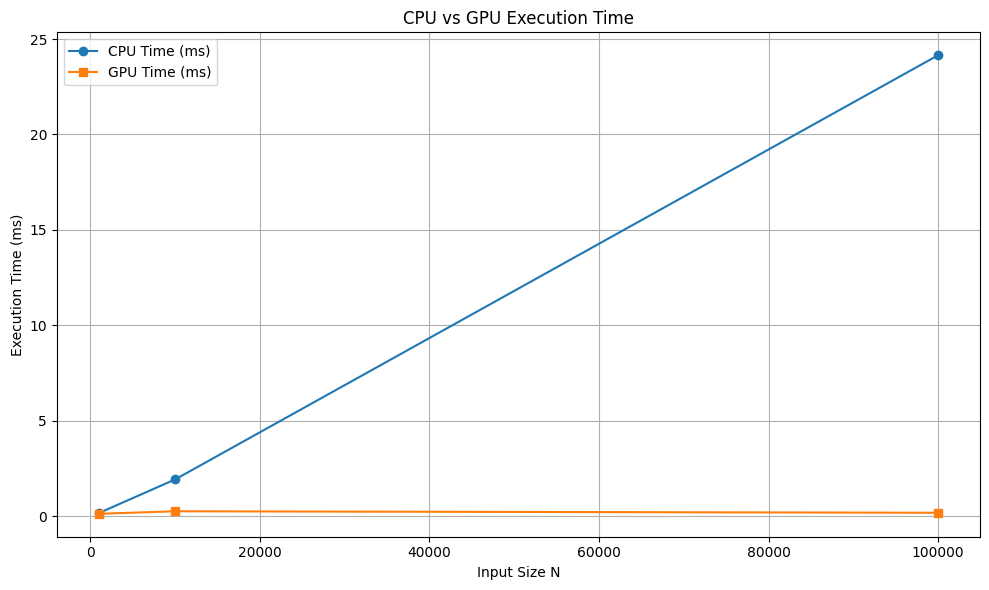

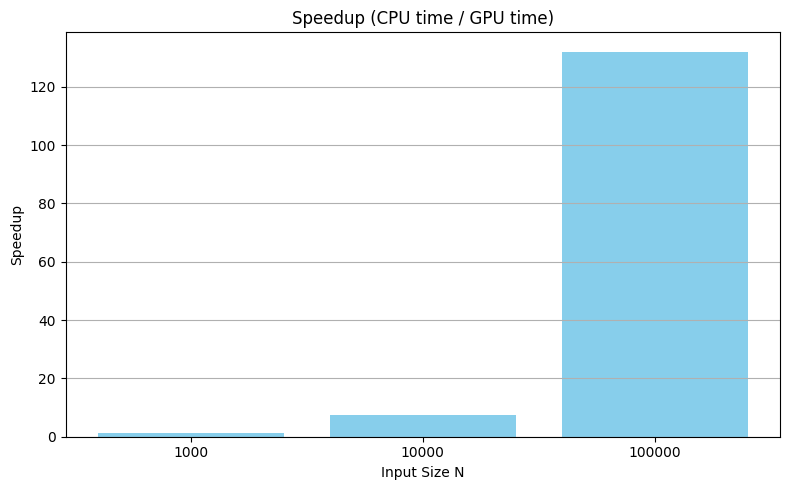

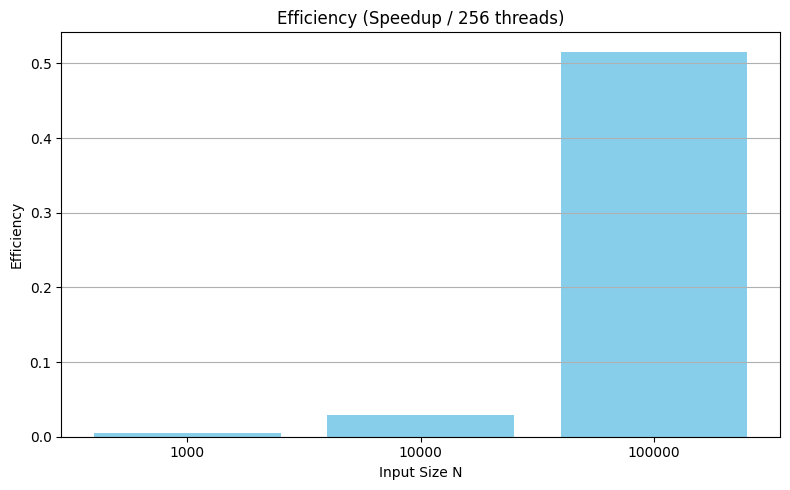

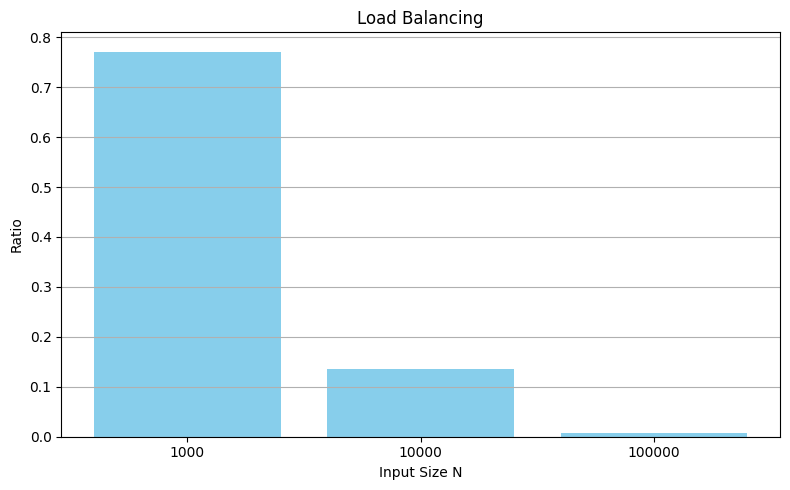

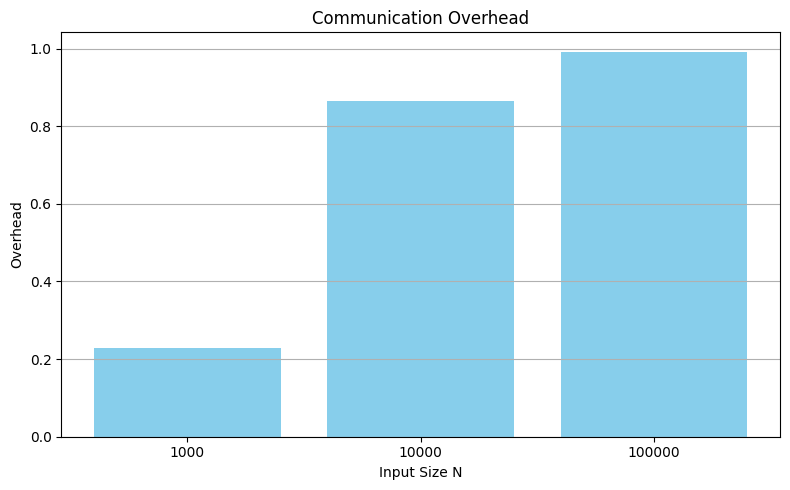

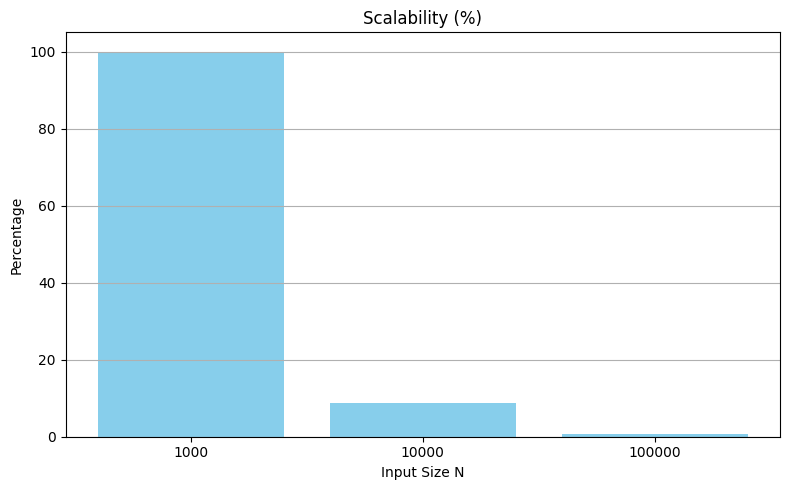

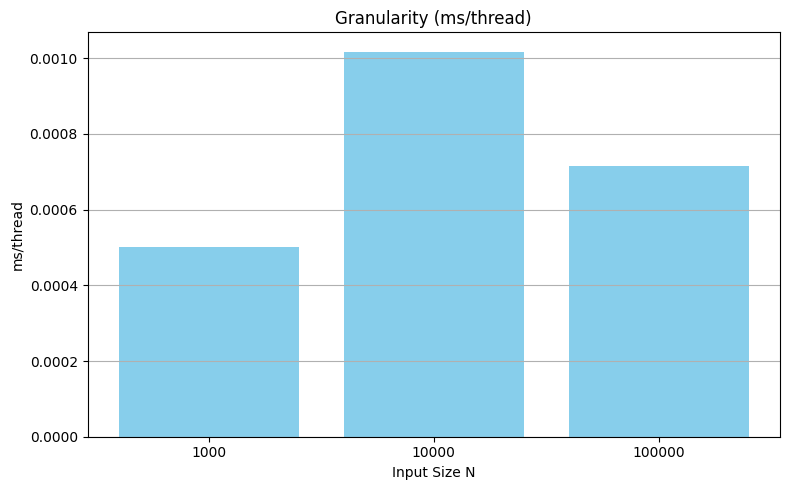

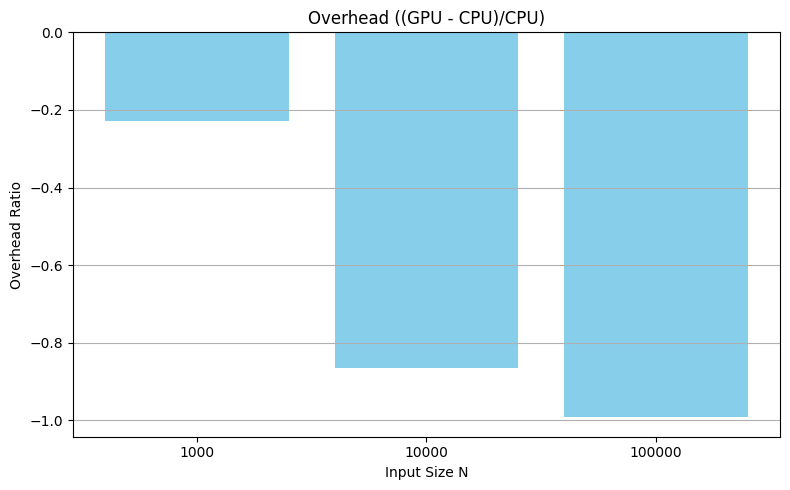

 Data exported to performance_metrics.xlsx


In [ ]:
import re
import matplotlib.pyplot as plt
import pandas as pd

# Read the output file
with open("output.txt", "r") as file:
    data = file.read()

# Extract N values in proper order (each N appears twice, take first occurrence only)
n_matches = re.findall(r"Elements for N = (\d+)", data)
n_values_all = [int(n) for n in n_matches]

n_values = []
seen = set()
for n in n_values_all:
    if n not in seen:
        seen.add(n)
        n_values.append(n)
# Extract GPU and CPU times
# Updated regex to match "gpu" instead of "GPU" to capture execution times correctly
gpu_times = [float(x) for x in re.findall(r"The elapsed time in GPU was ([\d.]+)", data)]
cpu_times = [float(x) for x in re.findall(r"The elapsed time in CPU was ([\d.]+)", data)]

# Calculate parameters
speedups = [cpu / gpu for cpu, gpu in zip(cpu_times, gpu_times)]
efficiencies = [s / 256 for s in speedups]
load_balancing = [min(cpu, gpu) / max(cpu, gpu) for cpu, gpu in zip(cpu_times, gpu_times)]
communication_overhead = [abs(cpu - gpu) / cpu for cpu, gpu in zip(cpu_times, gpu_times)]
scalability = [(cpu_times[0] / cpu) * 100 for cpu in cpu_times]
granularity = [gpu / 256 for gpu in gpu_times]
overheads = [(gpu - cpu) / cpu for gpu, cpu in zip(gpu_times, cpu_times)]

# Plotting CPU vs GPU Execution Time
plt.figure(figsize=(10, 6))
plt.plot(n_values, cpu_times, marker='o', label='CPU Time (ms)')
plt.plot(n_values, gpu_times, marker='s', label='GPU Time (ms)')
plt.title("CPU vs GPU Execution Time")
plt.xlabel("Input Size N")
plt.ylabel("Execution Time (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Function to create bar plots
def bar_plot(title, values, ylabel):
    plt.figure(figsize=(8, 5))
    plt.bar([str(n) for n in n_values], values, color='skyblue')
    plt.title(title)
    plt.xlabel("Input Size N")
    plt.ylabel(ylabel)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Plot all parameters
bar_plot("Speedup (CPU time / GPU time)", speedups, "Speedup")
bar_plot("Efficiency (Speedup / 256 threads)", efficiencies, "Efficiency")
bar_plot("Load Balancing", load_balancing, "Ratio")
bar_plot("Communication Overhead", communication_overhead, "Overhead")
bar_plot("Scalability (%)", scalability, "Percentage")
bar_plot("Granularity (ms/thread)", granularity, "ms/thread")
bar_plot("Overhead ((GPU - CPU)/CPU)", overheads, "Overhead Ratio")

# Export to Excel
df = pd.DataFrame({
    "N": n_values,
    "CPU Time (ms)": cpu_times,
    "GPU Time (ms)": gpu_times,
    "Speedup": speedups,
    "Efficiency": efficiencies,
    "Load Balancing": load_balancing,
    "Communication Overhead": communication_overhead,
    "Scalability (%)": scalability,
    "Granularity (ms/thread)": granularity,
    "Overhead Ratio": overheads
})

df.to_excel("performance_metrics.xlsx", index=False)
print(" Data exported to performance_metrics.xlsx")